In [ ]:
import torch
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from matplotlib.markers import MarkerStyle
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
batch_size = 3

In [ ]:
def sample_dataset(start, end, num_samples, noise):
     x = torch.linspace(start, end, num_samples)
     y = torch.linspace(start, end, num_samples)
     X, Y = torch.meshgrid(x, y)

     sample_mean = - torch.divide(1, 2*torch.pi**2) * torch.sin(torch.pi * X) * torch.cos(torch.pi * Y)
     sample_var = noise*np.ones_like(sample_mean)
     u = stats.norm(sample_mean, sample_var).rvs(random_state=444)

     return x, y, X, Y, u, sample_mean

In [ ]:
# Parameters for the training dataset
num_samples = 32
noise = 0.005
start = 0.0
end = 1.0

# Generate the dataset
x, y, X, Y, u, sample_mean = sample_dataset(start, end, num_samples, noise)

In [ ]:
print(X.flatten()[:5])
print(Y.flatten()[:5])

tensor([0., 0., 0., 0., 0.])
tensor([0.0000, 0.0323, 0.0645, 0.0968, 0.1290])


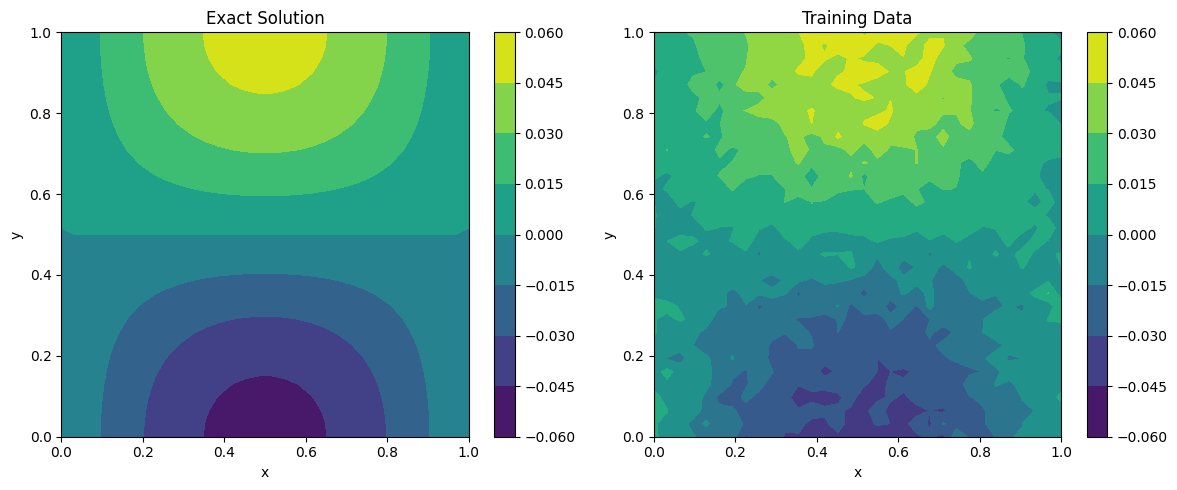

In [ ]:
# Create a figure with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the solution and noisy data
contour_sol = axs[0].contourf(X, Y, sample_mean, cmap='viridis')
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_title("Exact Solution")
fig.colorbar(contour_sol, ax=axs[0])

contour_u = axs[1].contourf(X, Y, u, cmap='viridis')
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("Training Data")
fig.colorbar(contour_sol, ax=axs[1])
plt.tight_layout()
plt.show()

In [ ]:
xy_train = torch.stack((X.flatten(), Y.flatten()), dim=1)
u_train = torch.Tensor(u.flatten()).unsqueeze(1)

train_dataset = TensorDataset(xy_train, u_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(xy_train[:5])
print(u_train[:5])
print(train_dataset[:5])

tensor([[0.0000, 0.0000],
        [0.0000, 0.0323],
        [0.0000, 0.0645],
        [0.0000, 0.0968],
        [0.0000, 0.1290]])
tensor([[ 0.0018],
        [ 0.0019],
        [ 0.0069],
        [ 0.0059],
        [-0.0047]])
(tensor([[0.0000, 0.0000],
        [0.0000, 0.0323],
        [0.0000, 0.0645],
        [0.0000, 0.0968],
        [0.0000, 0.1290]]), tensor([[ 0.0018],
        [ 0.0019],
        [ 0.0069],
        [ 0.0059],
        [-0.0047]]))


In [ ]:
print(xy_train.shape)
print(u_train.shape)
print(f"First 5 xy_train entries:\n{xy_train[:5]}")
print(f"\nFirst 5 u values:\n{u_train[:5]}")
print(f"\nFirst 5 x values:\n{x[:5]}")
print(f"\nFirst 5 y values:\n{y[:5]}")

torch.Size([1024, 2])
torch.Size([1024, 1])
First 5 xy_train entries:
tensor([[0.0000, 0.0000],
        [0.0000, 0.0323],
        [0.0000, 0.0645],
        [0.0000, 0.0968],
        [0.0000, 0.1290]])

First 5 u values:
tensor([[ 0.0018],
        [ 0.0019],
        [ 0.0069],
        [ 0.0059],
        [-0.0047]])

First 5 x values:
tensor([0.0000, 0.0323, 0.0645, 0.0968, 0.1290])

First 5 y values:
tensor([0.0000, 0.0323, 0.0645, 0.0968, 0.1290])


In [ ]:
class FeedForward(nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()

        self.optimizer = None
        self.train_loss_history = []

        self.hidden_size = 15

        # 2 input features
        self.b1 = nn.Linear(2, self.hidden_size)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.b3 = nn.Linear(self.hidden_size, 1)

        # weight initialization
        nn.init.xavier_uniform_(self.b1.weight)
        nn.init.xavier_uniform_(self.b2.weight)
        nn.init.xavier_uniform_(self.b3.weight)


    def forward(self, x, y):  # Pass in x and y instead of t
        X,Y = torch.meshgrid(x,y)

        # Combine x and y along the last dimension
        xy = torch.stack((X.flatten(), Y.flatten()), dim=1)

        # Pass the combined input through the network
        h1 = torch.tanh(self.b1(xy))
        h2 = torch.tanh(self.b2(h1))
        u = self.b3(h2)

        return u

    def compute_derivative(self, u, x, n):
        # General formula to compute the n-th order derivative of y = f(x) with respect to x
        if n == 0:
            return u
        else:
            du_dx = torch.autograd.grad(u, x, torch.ones_like(u).to(device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]

        return self.compute_derivative(du_dx, x, n - 1)

    def PDE_residual(self, x, y):
        u = self.forward(x, y)

        x.requires_grad=True
        y.requires_grad=True
        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)

        residual = d2u_dx2 + d2u_dy2 + torch.divide(1,2*torch.pi**2) * torch.cos(torch.pi*x)*torch.sin(torch.pi*y)  # Replace with your actual PDE Del^2 n - f

        return residual



#    def loss_data(self, x1, x2, u): #update variables
#        u_pred = self.forward(x1, x2)
#        loss_data = torch.mean(torch.square(u - u_pred))
#        return loss_data

    def loss_interior(self, num_samples=10): #uniform sampling x and y between [0,1] pass to PDE_residual
        x_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).flatten().requires_grad_(True)
        y_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).flatten().requires_grad_(True)
        res = self.PDE_residual(x_samples, y_samples)
        loss_residual = torch.mean(torch.square(res)) #like rms error

        return loss_residual

    def compute_losses(self):# a simple wrapper
        loss_interior = self.loss_interior()
        #loss_data = self.loss_data(tensor_x, tensor_y)
        #return loss_interior, loss_data
        return loss_interior

    def closure(self, w2=1):# update ... removed w1, w3
        self.optimizer.zero_grad()
        loss_interior = self.compute_losses() # removed loss_ic and loss_data
        total_loss = w2 * loss_interior    #removed w3 * loss_data
        total_loss.backward(retain_graph=True)
        return total_loss

# try to test in bits and pieces. plot results/outputs to sanity check. ie data_loss is working then etc. interior_loss

    def train(self, epochs, optimizer='Adam', **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)

            if epoch % 1000 == 0:  # Set the printing frequency
                loss_interior = self.compute_losses()     # removed loss_ic and loss_data
                total_loss = loss_interior   #removed loss_ic + loss_data

                self.train_loss_history.append([total_loss.cpu().detach().numpy(),  #removed loss_ic.cpu().detach().numpy(),
                                                loss_interior.cpu().detach().numpy() #removed loss_data.cpu().detach().numpy()
                                                ])

                print(f'Epoch ({optimizer}): {epoch}, Total Loss: {total_loss.detach().cpu().numpy()}')

    def get_training_history(self):
        loss_hist = np.array(self.train_loss_history)
        loss_interior = np.split(loss_hist, 2, axis=1) #removed total_loss, loss_ic,loss_data
        return total_loss, loss_interior   #removed loss_ic, loss_data

    def make_plot(self):
        # Get predictions
        u_pred = self.forward(x, y)

        # Create DataFrame from predictions
        data = {
            "x": list(x.squeeze().detach().numpy()),
            "y": list(y.squeeze().detach().numpy()),
            "u_pred": list(u_pred.squeeze().detach().numpy())
        }
        temp = pd.DataFrame.from_dict(data)

        # Pivot the DataFrame to create a grid for contour plotting
        grid_x, grid_y = np.meshgrid(
            np.unique(temp["x"]),
            np.unique(temp["y"])
        )
        grid_z = temp.pivot_table(index="y", columns="x", values="u_pred").values

        # Make the contour plot
        plt.figure(figsize=(8, 6))
        contour = plt.contour(grid_x, grid_y, grid_z, cmap='viridis')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Contour Plot of Predictions")
        plt.colorbar(contour)
        plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = FeedForward().to(device)
print(model)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

cpu
FeedForward(
  (b1): Linear(in_features=2, out_features=15, bias=True)
  (b2): Linear(in_features=15, out_features=15, bias=True)
  (b3): Linear(in_features=15, out_features=1, bias=True)
)
Params: 301


In [ ]:
print(model.forward(x.to(device),y.to(device)).shape) # Move x and y to the same device as the model

torch.Size([1024, 1])


In [ ]:
num_samples = 10
x_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).flatten().requires_grad_(True)
y_samples = torch.FloatTensor(num_samples, 1).uniform_(0, 1).flatten().requires_grad_(True)
print(model.PDE_residual(x_samples, y_samples).shape)
print(model.PDE_residual(x_samples, y_samples))

torch.Size([10])
tensor([ 1.1599,  0.1257, -0.4856, -1.5243,  0.9721,  0.8092,  0.5231,  0.3210,
        -1.1055, -1.6847], grad_fn=<AddBackward0>)


In [ ]:
model.loss_interior()

tensor(1.2269, grad_fn=<MeanBackward0>)

In [ ]:
model.compute_losses()

tensor(0.6672, grad_fn=<MeanBackward0>)

In [ ]:
input, output = next(iter(train_loader))

In [ ]:
model.train(25_000, lr=1e-4)

Epoch (Adam): 0, Total Loss: 1.2381422519683838
Epoch (Adam): 1000, Total Loss: 0.0013824256602674723
Epoch (Adam): 2000, Total Loss: 0.0025476892478764057
Epoch (Adam): 3000, Total Loss: 0.002285656053572893
Epoch (Adam): 4000, Total Loss: 0.0002009330492001027
Epoch (Adam): 5000, Total Loss: 0.00010022662172559649
Epoch (Adam): 6000, Total Loss: 0.0002244559582322836
Epoch (Adam): 7000, Total Loss: 0.00014136795653030276
Epoch (Adam): 8000, Total Loss: 0.00016805306950118393
Epoch (Adam): 9000, Total Loss: 8.351250289706513e-05
Epoch (Adam): 10000, Total Loss: 0.0006732040783390403
Epoch (Adam): 11000, Total Loss: 0.00018120839376933873
Epoch (Adam): 12000, Total Loss: 0.0002940440899692476
Epoch (Adam): 13000, Total Loss: 0.0002529705234337598
Epoch (Adam): 14000, Total Loss: 6.826374738011509e-05
Epoch (Adam): 15000, Total Loss: 0.00016270772903226316
Epoch (Adam): 16000, Total Loss: 0.0005088537000119686
Epoch (Adam): 17000, Total Loss: 0.0001715933613013476
Epoch (Adam): 18000, T

(100, 100)
torch.Size([100, 100])
torch.Size([100, 100])


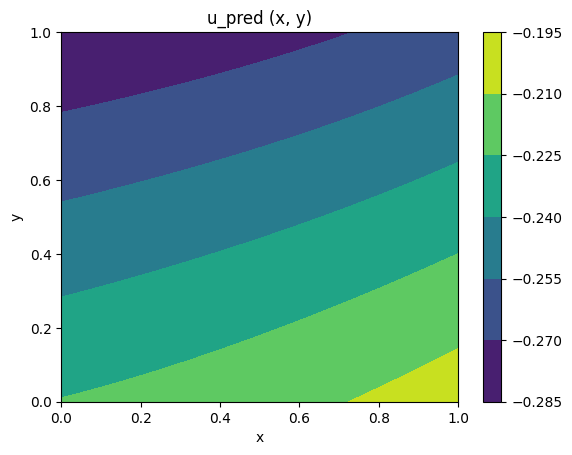

In [ ]:
x_test, y_test, X_test, Y_test, u, sample_mean_test = sample_dataset(0.0, 1.0, 100, noise=0.0)
u_pred = model.forward(x_test, y_test)
u_pred = u_pred.detach().numpy()
u_pred = u_pred.reshape(len(x_test), len(y_test))

print(u_pred.shape)
print(X_test.shape)
print(Y_test.shape)

contour = plt.contourf(X_test, Y_test, u_pred, cmap='viridis')

# Add a color bar to indicate the scale
plt.colorbar(contour)

# Label the axes
plt.xlabel("x")
plt.ylabel("y")
plt.title("u_pred (x, y)")

# Show the plot
plt.show()